In [1]:
import sys
sys.path.append("../../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from classy import Class

In [4]:
from axion_kSZ_source.axion_camb_wrappers.run_axion_camb import AxionCAMBWrapper
from axion_kSZ_source.theory.cosmology import Cosmology,CosmologyCustomH
from axion_kSZ_source.theory.sigma_interpolation import SigmaInterpolator
from axion_kSZ_source.theory.sigma_interpolation_FFTLog import SigmaInterpolatorFFTLog
from axion_kSZ_source.auxiliary.integration_helper import IntegrationHelper
from axion_kSZ_source.auxiliary.window_functions import WindowFunctions
from axion_kSZ_source.theory.mass_functions import PressSchechterMassFunction
from axion_kSZ_source.theory.halo_bias_new import HaloBias
from axion_kSZ_source.theory.correlation_functions import CorrelationFunctions
from axion_kSZ_source.theory.correlation_functions_FFTLog import CorrelationFunctions as CorrelationFunctionsFFTLog

In [5]:
cosmo = CosmologyCustomH.generate(axion_frac=0.5, h=0.72)
cosmoDefault = Cosmology.generate(omega_axion=1e-6, h=0.72)

In [6]:
outpath = "/Users/gerrit/SynologyDrive/College/Research/kSZ/source_code_test/sigma_tests/"
fileroot ="test"
log_path = outpath+"sigma_test_log.log"

camb = AxionCAMBWrapper(outpath, fileroot, log_path)
#camb(cosmo)

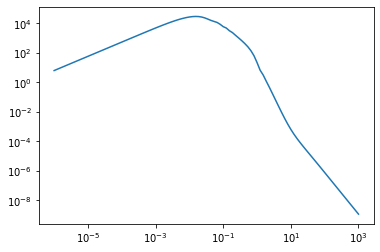

In [7]:
lin_power = camb.get_linear_power(extrap_kmax=1e3, extrap_kmin=1e-6)

k_vals = np.logspace(-6, 3, 100)
plt.loglog(k_vals, lin_power(k_vals))

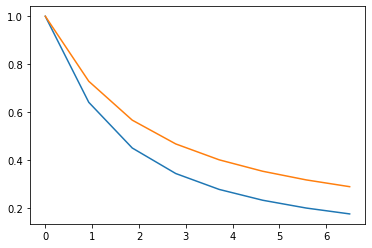

In [10]:
growth = camb.get_growth()
z_vals=np.linspace(0, 6.5, 8)
plt.plot(z_vals, growth(1e-2, z_vals))
plt.plot(z_vals, growth(1000, z_vals))

In [26]:
cosmo.set_H_interpolation(camb.get_hubble())

In [27]:
intHelper = IntegrationHelper(2048)

In [28]:
window="sharp_k"

In [29]:
sigmaInt = SigmaInterpolator(cosmo, lin_power, growth, 1e14, 1e16, z_vals, intHelper, Nr=1024, window_function=window)
sigmaInt.compute(1e-4, 1e3)

In [30]:
sigmaIntFFTLog = SigmaInterpolatorFFTLog(cosmo, lin_power, growth, z_vals, 1e-4, 1e3, Nr=1024, window_function=window)
sigmaIntFFTLog.compute()

/Users/gerrit/.pyenv/versions/3.7.5/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


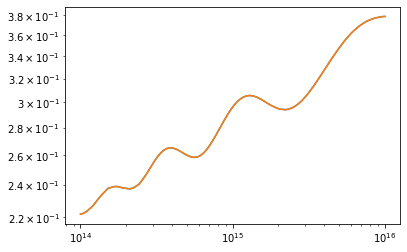

In [31]:
m_vals = np.logspace(14, 16, 100)
plt.loglog(m_vals, -sigmaInt.dlogSigma_dlogm(m_vals, 0.0))
plt.loglog(m_vals, -sigmaIntFFTLog.dlogSigma_dlogm(m_vals, 0.0))

In [32]:
ps_mass_function = PressSchechterMassFunction(cosmo, sigmaInt)
hbGW = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="gaussian")
hbGW.compute_approximation()
hbTH = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="top_hat")
hbTH.compute_approximation()
hbSK = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="sharp_k")
hbSK.compute_approximation()

../../axion_kSZ_source/theory/halo_bias_new.py:69: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  self._m_mean = np.array([spIntegrate(lambda logM: np.exp(logM) * self._mass_function(np.exp(logM), z), np.log(self._mMin), np.log(self._mMax))[0] for z in self._z_vals]) / self._nbar
../../axion_kSZ_source/theory/halo_bias_base.py:29: RuntimeWarning: The given value of k_max=1.00E+01 is not feasible because you chose a sharp-k filter and a maximum mass of m_min=1.00E+14. k_max has instead be set to 2.85E-01
  warnings.warn(f"The given value of k_max={kMax:.2E} is not feasible because y

In [33]:
hb = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="sharp_k")
hb.compute()

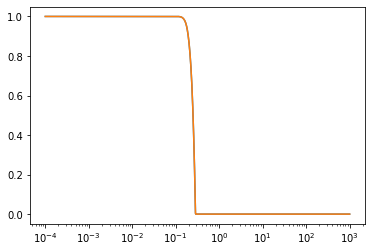

In [34]:
k_vals = np.logspace(-4, 3, 1000)
#plt.semilogx(k_vals, hbGW(k_vals, z_vals[0], 0.0))
#plt.semilogx(k_vals, hbTH(k_vals, z_vals[0], 0.0))
plt.semilogx(k_vals, hbSK(k_vals, z_vals[0], 0.0))
plt.semilogx(k_vals, hb(k_vals, z_vals[0], 0.0))


In [35]:
kMesh,zMesh,dump = np.meshgrid(k_vals, z_vals, np.ones((3)))
hb(kMesh, zMesh, 1.0).shape

(8, 1000, 3)

In [47]:
r_vals = np.linspace(1e-3, 200, 100)
corr = CorrelationFunctions(cosmo, lin_power, growth, hb, 1e-4, 1e3, z_vals, 1e-3, r_vals, intHelper)
dump = corr.compute(unbiased=True)

In [48]:
def compute_v(correlations):
    xi_unbiased, xi, dbarxi_dloga_unbiased, dbarxi_dloga =  correlations.get_correlation_functions(rMesh, zMesh, unbiased=True)
    v = r_vals * 100 * dbarxi_dloga / (3 * (1 + xi))
    v_dm = r_vals * 100 * dbarxi_dloga_unbiased / (3 * (1 + xi_unbiased))

    return v, v_dm

In [49]:
corrFFTLog = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hb, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLog.compute(unbiased=True)
corrFFTLogGW = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hbGW, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLogGW.compute(unbiased=True)
corrFFTLogTH = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hbTH, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLogTH.compute(unbiased=True)
corrFFTLogSK = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hbSK, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLogSK.compute(unbiased=True)

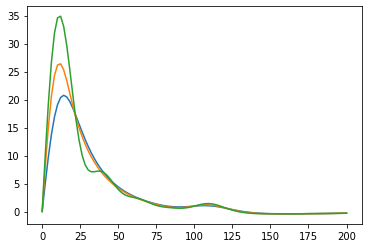

In [50]:
rMesh,zMesh=np.meshgrid(r_vals, z_vals)
plt.plot(r_vals, r_vals*corrFFTLogGW.get_correlation_functions(rMesh, zMesh, unbiased=True)[1][0])
plt.plot(r_vals, r_vals*corrFFTLogTH.get_correlation_functions(rMesh, zMesh, unbiased=True)[1][0])
plt.plot(r_vals, r_vals*corrFFTLogSK.get_correlation_functions(rMesh, zMesh, unbiased=True)[1][0])

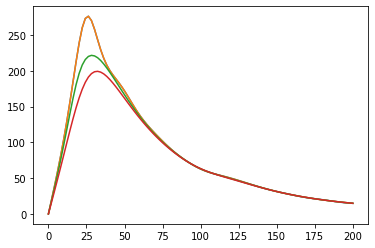

In [68]:
#plt.plot(r_vals, compute_v(corrFFTLog)[0][0]/compute_v(corrFFTLogSK)[0][0])
plt.plot(r_vals, compute_v(corr)[0][0])
plt.plot(r_vals, compute_v(corrFFTLogSK)[0][0])
plt.plot(r_vals, compute_v(corrFFTLogTH)[0][0])
plt.plot(r_vals, compute_v(corrFFTLogGW)[0][0])

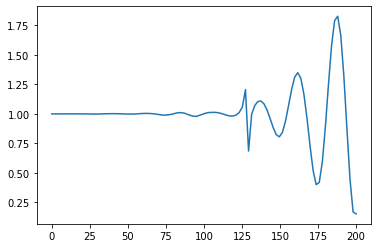

In [52]:
rMesh,zMesh = np.meshgrid(r_vals, z_vals)
fft_xi_lin, fft_xi, fft_out_dbarxi_dloga_lin, fft_out_dbarxi_dloga  = corrFFTLog.get_correlation_functions(rMesh, zMesh, unbiased=True)
xi_lin, xi, out_dbarxi_dloga_lin, out_dbarxi_dloga  = corr.get_correlation_functions(rMesh, zMesh, unbiased=True)
#plt.plot(r_vals, r_vals*fft_xi[0])
plt.plot(r_vals, xi[0]/fft_xi[0])
#plt.plot(r_vals, r_vals*xi[0])
#plt.plot(r_vals, r_vals*fft_xi_lin[0])
#plt.plot(r_vals, r_vals*xi_lin[0])

/Users/gerrit/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


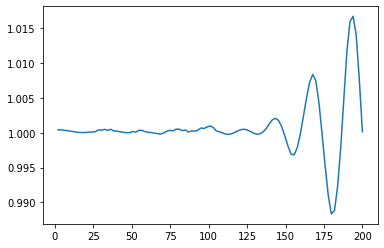

In [64]:
plt.plot(r_vals, fft_out_dbarxi_dloga[0]/out_dbarxi_dloga[0])
#plt.plot(r_vals, )
#plt.plot(r_vals, r_vals*fft_out_dbarxi_dloga_lin[0])
#plt.plot(r_vals, r_vals*out_dbarxi_dloga_lin[0])

In [54]:
r, lin_xi_fft, lin_dxi_fft, nonlin_xi_fft, nonlin_dxi_fft = corrFFTLog.compute_xi(z_vals, deriv=True, unbiased=True)

/Users/gerrit/.pyenv/versions/3.7.5/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [55]:
lin_xi, lin_dxi, nonlin_xi, nonlin_dxi = corr.compute_xi(r, z_vals, deriv=True, unbiased=True)

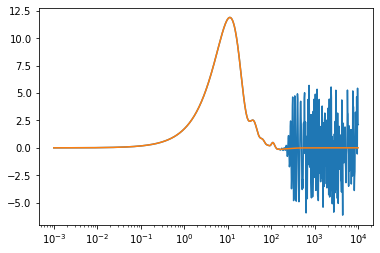

In [60]:
plt.semilogx(r, r*nonlin_dxi[0])
plt.semilogx(r, r*nonlin_dxi_fft[0])

In [57]:
1-nonlin_dxi[0]/nonlin_dxi_fft[0]

array([ 4.14076874e-04,  4.16937694e-04,  4.14103738e-04, ...,
       -5.23108950e+07, -3.78888943e+06,  7.02308611e+05])

In [58]:
1-nonlin_xi[0]/nonlin_xi_fft[0]

array([ 3.43964752e-04,  3.46866136e-04,  3.43992149e-04, ...,
       -2.93857463e+07, -3.40901702e+06,  6.78743343e+05])

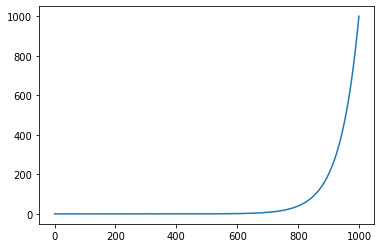

In [82]:
fig=plt.figure().add_subplot()

fig.plot(k_vals)

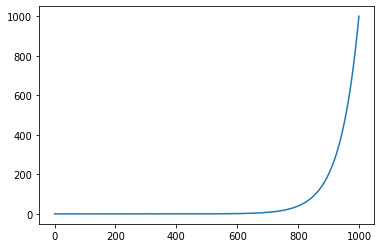